In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
ls .\Data\*.tsv

In [4]:
data = pd.read_csv('.\Data\cleaned.csv', delimiter='\t',encoding='utf-8',usecols=['Title','Description','Requirements'], error_bad_lines=False, nrows = 10000)

In [5]:
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aaquibladiwala\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
data.head()

,Title,Description,Requirements
0,Security Engineer/Technical Lead,Security Clearance Required: Top Secret \rJob...,SKILL SET\r \rNetwork Security tools:\r \rWebd...
1,SAP Business Analyst / WM,NO Corp. to Corp resumes are being considered ...,WHAT YOU NEED: \rFour year college degree\rMin...
2,P/T HUMAN RESOURCES ASSISTANT,P/T HUMAN RESOURCES ASSISTANT —— 1-2 year...,Please refer to the Job Description to view th...
3,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...
4,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...


In [55]:
def text_scrubber(values):
    
    '''
        Replace problematic phrases and unicode characters.
        
        (10+ years) ---> ''
        &#39; , \x92 ---> apostrophe
        Technical: ---> ''
        
        These characters act usually as separators, so replace them with commas for splitting later.
            [:, ;, &amp;, \x95, &, ., /, 'and'] ---> ','
        
    '''

    result = []
    for string in values:
        # Regex as explained above
        temp = re.sub('(\(.*\))', '', string)
        temp = re.sub('&#39;|\x92', '\'', temp)
        temp = re.sub(' &amp; |&amp;|\x95|:|;|&|\.|/| and ', ',', temp)
        temp = re.sub('\w*:\s+', ', ', temp)
        
        result.append(temp)
        
    return result

def tokenizer(data):
    
    
    '''
        Parse the given skills dataframe to pull out appropriate skill phrases.
        Dataframe has some cells that are 2-gram nicely made skills, and other cells
        that are long runons with many skills.
        After scrubbing and then splitting on commas, we simplify the task by tossing
        out any greater than 4-gram phrases. 
    '''
    
    # Custom stop words that come up very often but don't say much about the job title.
    stops = ['manager', 'responsibilities', 'used', 'skills', 'duties', 'work', 'worked', 'daily',
             'services', 'job', 'using', '.com', 'end', 'prepare', 'prepared', 'lead', 'requirements','#39'] + list(stopwords.words('english'))
    values, ids, resume_ids = [],[],[]
    count = 0
    for idx, row in data.iterrows():
        
        # Split on commas
        array = row['Requirements'].lower().split(',')
        for x in array:
            # make sure the value is not empty or all numeric values or in the stop words list
            if x != '' and not x.lstrip().rstrip() in stops and not x.lstrip().rstrip().isdigit():
                # make sure single character results are the letter 'C' (programming language)
                if len(x) > 1 or x == 'C':
                    # drop stuff > 4 gram
                    if len(x.split(' ')) <= 4:
                        # update lists
                        
                        values.append(x.lstrip().rstrip())
                        ids.append(count)
                        count+=1
    
    # New dataframe with updated values.
    result_df = pd.DataFrame()
    
    result_df['Requirements'] = values
    return result_df

data2 = data.copy()
data2['Requirements'] = data['Requirements'].astype(str)
data2['Requirements'] = text_scrubber(data['Requirements'])
data2['Requirements'] = data.Requirements.str.replace(r'\r\n', '')
test_data = tokenizer(data)

voc = test_data['Requirements'].unique()

In [56]:
test_data.head(50)

,Requirements
0,skill set\r \rnetwork security tools
1,\r \rweb application tools
2,\r \rappdective
3,fortify sca
4,hp webinspect
5,the like
6,\r \rnetwork vulnerability tools
7,\r \rtenable security center
8,mcafee foundstone scanner
9,cain


In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from pylab import rcParams

In [10]:
data['Description'] = data['Description'].astype(str)

In [11]:
data['Description'] = [x.replace("&nbsp;"," ").replace("\x92"," ").replace("\x95"," ").replace('&amp;'," ") \
                             .replace('*'," ").replace("."," ").replace("co&#39;s","").replace("\xae&quot;","") \
                             .replace("&#39;s","").replace("&quot;","").replace("?","").replace("&#39;s","") \
                             .replace("@","").replace("\x96","")
                             for x in data['Description']]

mine = ['manager', 'amp', 'nbsp', 'responsibilities', 'used', 'skills', 'duties', 'work', 'worked', 'daily',
       'services', 'job', 'using', 'com', 'end', 'prepare', 'prepared', 'lead', 'requirements']
vec = TfidfVectorizer(analyzer='word', ngram_range=(1,2), token_pattern='[a-zA-z]{3,50}', max_df=0.2, min_df=2,
                      max_features=10000, stop_words=text.ENGLISH_STOP_WORDS.union(mine), decode_error='ignore', vocabulary=None, binary=False)

description_matrix2 = vec.fit_transform(data['Requirements']+data['Description'])
description_matrix2 = pd.DataFrame(description_matrix2.todense())
description_matrix2.columns = vec.get_feature_names()

In [13]:
vec2 = TfidfVectorizer(vocabulary=voc, decode_error='ignore')
skills_matrix2 = vec2.fit_transform(data['Requirements']+data['Description'])
skills_matrix2 = pd.DataFrame(skills_matrix2.todense())
skills_matrix2.columns = vec2.get_feature_names()

In [14]:
jobtitle_matrix = pd.concat([skills_matrix2, description_matrix2], axis=1)

In [15]:
pca = PCA(n_components=1000, random_state=42)
comps = pca.fit_transform(jobtitle_matrix)

In [25]:

# Put the components into a dataframe

comps = pd.DataFrame(comps)

In [26]:
cltr = AgglomerativeClustering(n_clusters=8)
cltr.fit(comps)

# Add new column containing cluster number to sample, comps, and feature matrix dataframes
data['cluster_no'] = cltr.labels_

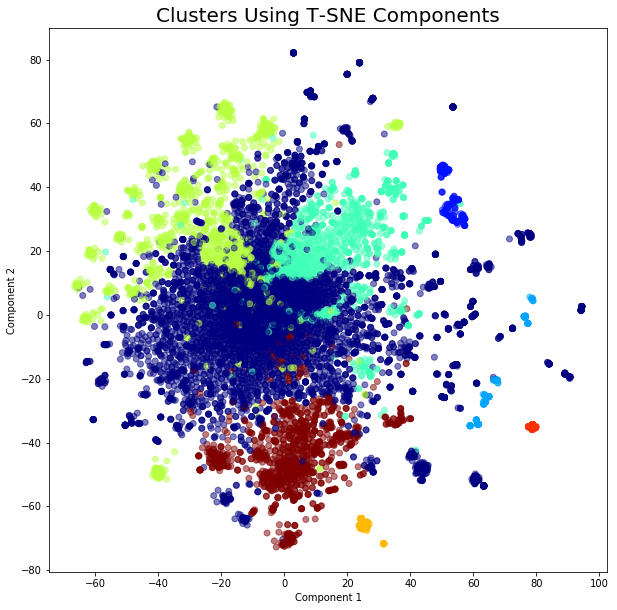

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE()
g = pd.DataFrame(tsne.fit_transform(comps), columns=['one', 'two'])


g['cluster_no'] = cltr.labels_

import matplotlib.cm as cm

plt.figure(figsize=(10,10))
plt.title('Clusters Using T-SNE Components', fontsize=20)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.scatter(g['one'], g['two'], c=g['cluster_no'], cmap=cm.jet, alpha=0.5)

plt.show()

In [28]:
X = comps
y = data['cluster_no']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
lr = LogisticRegression(C=10, penalty='l2', multi_class='multinomial', solver='sag', max_iter=1000)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9388

In [30]:
lr.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
comps['cluster_no'] = y.values
comps.set_index('cluster_no', inplace=True)

In [52]:
data_text = "developer java python tableau html css javascript node powerbi microstartegy machine learning cloud computing reporting"

In [48]:
def give_suggestions(resume_text):
    # Vectorize user's skills and job descriptions
    desc = pd.DataFrame(vec.transform([resume_text]).todense())
    desc.columns = vec.get_feature_names()
    skillz = pd.DataFrame(vec2.transform([resume_text]).todense())
    skillz.columns = vec2.get_feature_names()
    mat = pd.concat([skillz, desc], axis=1)

    # Tranform feature matrix with pca
    user_comps = pd.DataFrame(pca.transform(mat))

    # Predict cluster for user and print cluster number
    cluster = lr.predict(user_comps)[0]
    print ('CLUSTER NUMBER', cluster, '\n\n')

    # Calculate cosine similarity
    cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==cluster]))

    # Get job titles from sample2 to associate cosine similarity scores with jobs
    data_for_cluster = data[data['cluster_no']==cluster]
    cos_sim = cos_sim.T.set_index(data_for_cluster.index)
    cos_sim.columns = ['score']

    # Print the top ten suggested jobs for the user's cluster
    print ('Top ten suggested for your cluster', '\n', cos_sim.sort_values('score', ascending=False)[:10], '\n\n')

    # Print the top five suggested jobs for each cluster
    mat = mat.T
    for i in range(8):
        cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==i]))
        data_for_cluster = data[data['cluster_no']==i]
        cos_sim = cos_sim.T.set_index(data_for_cluster.index)
        cos_sim.columns = ['score']
        top_5 = cos_sim.sort_values('score', ascending=False)[:5]

        # Merge top_5 with sample2 to get skills and description
        merged_top_5 = top_5.merge(data, how='left', left_index=True, right_index=True)
        print ('---------Top five suggested in cluster', i,  '---------\n', top_5, '\n\n')
        # Vectorize to find skills needed for each job title

        for job in merged_top_5.index:
            job_skills = pd.DataFrame(vec2.transform([merged_top_5.ix[job]['Description']+merged_top_5.ix[job]['Requirements']]).todense())
            job_skills.columns = vec2.get_feature_names()
            job_skills = job_skills.T
            job_skills.columns = ['score']
            job_skills = job_skills[job_skills['score'] != 0].sort_values('score', ascending=False)
            mat.columns = ['score']
            mat = mat[mat['score'] != 0]
            needed_skills = []
            scorey = []
            for i in job_skills.index:
                if i not in mat.index:    
                    needed_skills.append(i)
                    scorey.append(job_skills.ix[i][0])
            top_skills = pd.DataFrame(zip(needed_skills, scorey), columns=['Skills', 'Importance'])
            top_skills.head()

In [57]:
give_suggestions(data_text)

CLUSTER NUMBER 0 


Top ten suggested for your cluster 
          score
6147  0.511054
6374  0.425284
6627  0.333181
2574  0.330003
5977  0.268308
6571  0.268099
1516  0.266718
1520  0.266718
1523  0.266718
1356  0.266718 


---------Top five suggested in cluster 0 ---------
          score
6147  0.511054
6374  0.425284
6627  0.333181
2574  0.330003
5977  0.268308 




C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: Deprecatio

---------Top five suggested in cluster 1 ---------
          score
1839  0.005617
1827  0.003870
1818  0.003662
1931  0.003633
1775  0.003491 


---------Top five suggested in cluster 2 ---------
          score
1048  0.015512
1077  0.015512
1202  0.015512
978   0.010651
1011  0.010651 




C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: Deprecatio

---------Top five suggested in cluster 3 ---------
          score
3388  0.172438
4024  0.134177
3351  0.129168
6977  0.091068
727   0.071448 


---------Top five suggested in cluster 4 ---------
          score
272   0.357835
8207  0.229782
7975  0.216267
149   0.205785
7982  0.200394 




C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: Deprecatio

---------Top five suggested in cluster 5 ---------
          score
9666 -0.060836
9781 -0.060836
9783 -0.060836
9784 -0.060836
9785 -0.060836 


---------Top five suggested in cluster 6 ---------
         score
9917 -0.05366
9979 -0.05366
9977 -0.05366
9976 -0.05366
9975 -0.05366 




C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: Deprecatio

---------Top five suggested in cluster 7 ---------
          score
2573  0.546230
5076  0.501229
4476  0.486025
5939  0.465369
5940  0.465181 




C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\aaquibladiwala\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: Deprecatio